In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from scipy.spatial import KDTree
import numpy as np

# Additional imports
import pystac_client
import xarray as xr
import pathlib
import os
import geopandas as gpd
import matplotlib as mpl
from matplotlib import colors
import rasterio

import cartopy.crs as ccrs
import cartopy
import plotly.graph_objects as go
import plotly.express as px
from rasterio.plot import show

import matplotlib.colors as mcolors
from shapely.geometry import Point
import pandas as pd

from tqdm import tqdm

import webbrowser
from pathlib import Path
import os
import time

from itertools import compress
import pandas as pd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import plotly.graph_objects as go
import plotly.express as px

from tqdm import tqdm

from shapely.geometry import box


C:\Users\rowe\AppData\Local\Temp\ipykernel_11120\1232273867.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


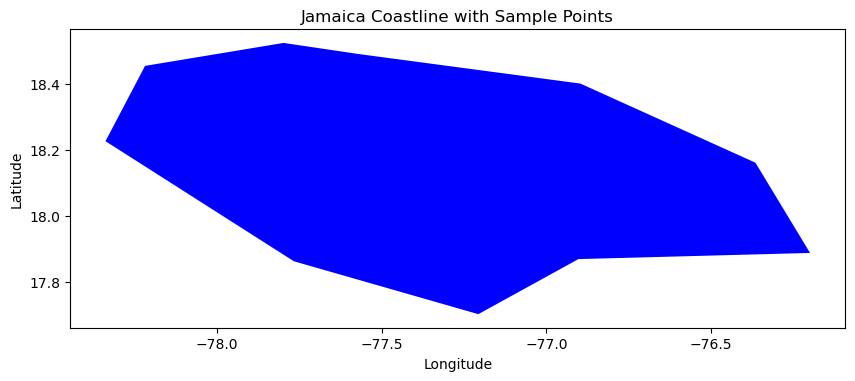

In [2]:
import geopandas as gpd

# Load the world dataset which includes country boundaries and coastlines
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the coastline for Jamaica
jamaica_coastline = world[world['name'] == 'Jamaica']['geometry'].unary_union

# Check if it's a MultiLineString, if so, convert to LineString
if jamaica_coastline.geom_type == 'MultiLineString':
    jamaica_coastline = jamaica_coastline[0]

# Save the LineString to a GeoDataFrame
jamaica_coastline_gdf = gpd.GeoDataFrame(geometry=[jamaica_coastline], crs=world.crs)

# Visualize or process the Jamaica coastline
# Plot both the coastline and the points
ax = jamaica_coastline_gdf.plot(color='blue', figsize=(10, 8))

ax.set_title('Jamaica Coastline with Sample Points')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal')

C:\Users\rowe\AppData\Local\Temp\ipykernel_11120\4010667350.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


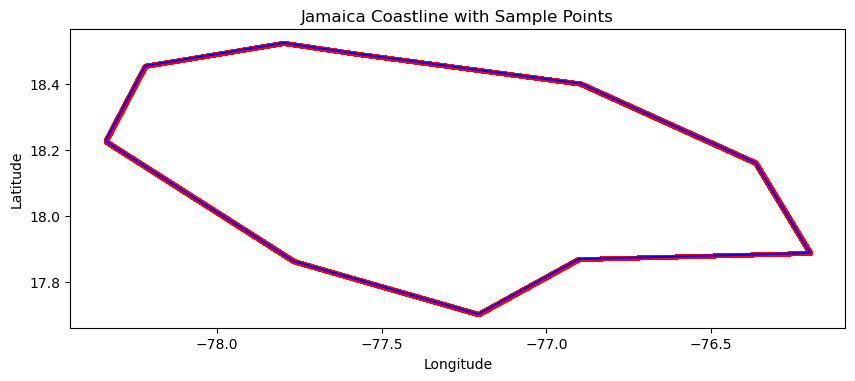

In [3]:
import geopandas as gpd
from shapely.geometry import Point, LineString

# Load the GeoDataFrame containing the Jamaica coastline Polygon
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
jamaica_coastline_polygon = world[world['name'] == 'Jamaica']['geometry'].unary_union
if jamaica_coastline_polygon.geom_type == 'MultiPolygon':
    jamaica_coastline_polygon = jamaica_coastline_polygon[0]  # Assuming only one polygon
jamaica_coastline = jamaica_coastline_polygon.exterior  # Extract exterior boundary
jamaica_coastline_gdf = gpd.GeoDataFrame(geometry=[jamaica_coastline], crs=world.crs)

# Create sample points along the coastline
points = []
distance_along_line = 0
while distance_along_line < jamaica_coastline.length:
    point = jamaica_coastline.interpolate(distance_along_line)
    points.append(point)
    distance_along_line += 0.0001  # 100 meters spacing
points_gdf = gpd.GeoDataFrame(geometry=points, crs=world.crs)

# Plot both the coastline and the points
ax = jamaica_coastline_gdf.plot(color='blue', figsize=(10, 8))
points_gdf.plot(ax=ax, color='red', markersize=5)
ax.set_title('Jamaica Coastline with Sample Points')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal')



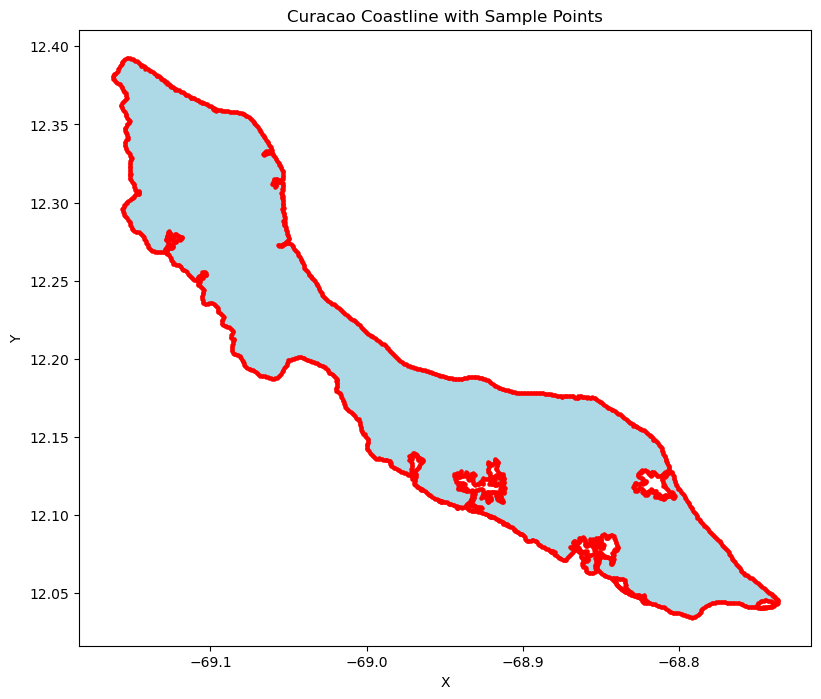

In [4]:
import geopandas as gpd
from shapely.geometry import MultiPolygon, LineString

# Load the GeoDataFrame containing the polygon from the GeoPackage file
polygon_gdf = gpd.read_file(r'P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\All_Datasets\Orig_Datasets\04_Auxillary_files\Curacao_Polygon.gpkg')
polygon_gdf=polygon_gdf.to_crs(crs="EPSG:4326")

# Merge all geometries into a single MultiPolygon
multi_polygon = polygon_gdf['geometry'].unary_union

# Convert the MultiPolygon to a LineString representing the coastline
coastline_line = LineString(multi_polygon.boundary.coords)

# Create sample points along the coastline
points = []
distance_along_line = 0
while distance_along_line < coastline_line.length:
    point = coastline_line.interpolate(distance_along_line)
    points.append(point)
    distance_along_line += 0.001  # 100 meters spacing

# Create a GeoDataFrame for the points
points_gdf = gpd.GeoDataFrame(geometry=points, crs=polygon_gdf.crs)

# Plot both the coastline and the points
ax = polygon_gdf.plot(color='lightblue', figsize=(10, 8))
points_gdf.plot(ax=ax, color='red', markersize=5)
ax.set_title('Curacao Coastline with Sample Points')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')


In [5]:
points_gdf.index

RangeIndex(start=0, stop=2440, step=1)

In [6]:
print("Length of coastline LineString:", coastline_line.length)
print("Number of generated points:", len(points))
points_gdf["distance"]=points_gdf.index*100
points_gdf

Length of coastline LineString: 2.439015453209153
Number of generated points: 2440


,geometry,distance
0,POINT (-68.84834 12.06170),0
1,POINT (-68.84912 12.06225),100
2,POINT (-68.84990 12.06286),200
3,POINT (-68.85070 12.06346),300
4,POINT (-68.85136 12.06419),400
...,...,...
2435,POINT (-68.84468 12.06005),243500
2436,POINT (-68.84559 12.06048),243600
2437,POINT (-68.84652 12.06084),243700
2438,POINT (-68.84744 12.06124),243800


In [7]:
check_distance=0.01
# buffer_circles = gpd.GeoDataFrame([Polygon(p.buffer(check_distance)) for p in circle_center[0][:5]])
buffer_circles = gpd.GeoDataFrame({'geometry': [Polygon(p.buffer(check_distance)) for p in points_gdf['geometry']]})

In [8]:
circle_center=points_gdf


Loading Nearshore Slopes

In [281]:
df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\02_Exposure\Nearshore_Slopes\Netherland_Antilles_NS.csv")
data_points = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Intersect_lon, df.Intersect_lat), crs="EPSG:4326"
)
data_points

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,geometry,sampled points,slope
0,BOX_117_121_0,NLD,Europe,Netherlands,-68.395427,12.295109,-68.401033,12.301967,-68.406639,12.308825,POINT (-68.40103 12.30197),2.0,2.571829
1,BOX_117_121_1,NLD,Europe,Netherlands,-68.398505,12.292725,-68.404540,12.299226,-68.410576,12.305726,POINT (-68.40454 12.29923),2.0,2.571829
2,BOX_117_121_2,NLD,Europe,Netherlands,-68.401179,12.289979,-68.407654,12.296063,-68.414129,12.302147,POINT (-68.40765 12.29606),3.0,1.955613
3,BOX_117_121_3,NLD,Europe,Netherlands,-68.402839,12.287514,-68.410244,12.292483,-68.417649,12.297452,POINT (-68.41024 12.29248),2.0,1.955613
4,BOX_117_121_4,NLD,Europe,Netherlands,-68.403989,12.284926,-68.412179,12.288531,-68.420369,12.292136,POINT (-68.41218 12.28853),3.0,2.997358
...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,BOX_117_117_139,NLD,Europe,Netherlands,-68.301764,12.158128,-68.300464,12.166817,-68.299164,12.175506,POINT (-68.30046 12.16682),2.0,2.392250
619,BOX_117_117_140,NLD,Europe,Netherlands,-68.306208,12.158764,-68.304908,12.167453,-68.303608,12.176142,POINT (-68.30491 12.16745),2.0,3.694947
620,BOX_117_117_141,NLD,Europe,Netherlands,-68.309252,12.158884,-68.309381,12.167664,-68.309510,12.176445,POINT (-68.30938 12.16766),2.0,3.694947
621,BOX_117_117_142,NLD,Europe,Netherlands,-68.313743,12.158821,-68.313872,12.167601,-68.314001,12.176382,POINT (-68.31387 12.16760),2.0,2.723424


In [282]:


import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

for i in tqdm(range(0,len(buffer_circles['geometry'])),desc="Transects checked"):
    #inside_points = data_points[data_points.within(buffer_circles.iloc[i]['geometry'])]
    inside_points = data_points[data_points.within(buffer_circles.loc[i,'geometry'])]
    
    # Calculate distance
   
    inside_points.loc[:,'distance'] = inside_points.geometry.distance(circle_center.geometry[i])

    # Sort inside_points by 'distance' in ascending order
    sorted_inside_points = inside_points.sort_values(by='distance')

    # Select the top 2 rows
    nearest_point = sorted_inside_points.head(1)

    if len(inside_points['geometry'])==0:
            circle_center.loc[i,'sampled points']=0
            circle_center.loc[i,'slope']=np.nan
            continue
    
    if len(inside_points['geometry'])>0:
        circle_center.loc[i,'sampled points']=len(inside_points['geometry'])
        circle_center.loc[i,'slope']=nearest_point["slope"].values
        continue
# Suppress all warnings
warnings.filterwarnings("ignore")
circle_center

Transects checked: 100%|██████████| 2440/2440 [01:55<00:00, 21.20it/s]


,geometry,distance,sampled points,slope
0,POINT (-68.84834 12.06170),0,4.0,4.010837
1,POINT (-68.84912 12.06225),100,4.0,4.010837
2,POINT (-68.84990 12.06286),200,4.0,4.010837
3,POINT (-68.85070 12.06346),300,4.0,4.010837
4,POINT (-68.85136 12.06419),400,4.0,0.003349
...,...,...,...,...
2435,POINT (-68.84468 12.06005),243500,4.0,4.010837
2436,POINT (-68.84559 12.06048),243600,4.0,4.010837
2437,POINT (-68.84652 12.06084),243700,4.0,4.010837
2438,POINT (-68.84744 12.06124),243800,4.0,4.010837


Loading World_Pop

In [283]:
df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\02_Exposure\world_pop\Netherland_Antilles_world_pop.csv")
data_points = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Intersect_lon, df.Intersect_lat), crs="EPSG:4326"
)
data_points

,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,geometry,sampled points,pop_count
0,BOX_117_121_0,NLD,Europe,Netherlands,-68.395427,12.295109,-68.401033,12.301967,-68.406639,12.308825,POINT (-68.40103 12.30197),1.0,7.0
1,BOX_117_121_1,NLD,Europe,Netherlands,-68.398505,12.292725,-68.404540,12.299226,-68.410576,12.305726,POINT (-68.40454 12.29923),0.0,0.0
2,BOX_117_121_2,NLD,Europe,Netherlands,-68.401179,12.289979,-68.407654,12.296063,-68.414129,12.302147,POINT (-68.40765 12.29606),0.0,0.0
3,BOX_117_121_3,NLD,Europe,Netherlands,-68.402839,12.287514,-68.410244,12.292483,-68.417649,12.297452,POINT (-68.41024 12.29248),0.0,0.0
4,BOX_117_121_4,NLD,Europe,Netherlands,-68.403989,12.284926,-68.412179,12.288531,-68.420369,12.292136,POINT (-68.41218 12.28853),0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,BOX_117_117_139,NLD,Europe,Netherlands,-68.301764,12.158128,-68.300464,12.166817,-68.299164,12.175506,POINT (-68.30046 12.16682),2.0,11.0
619,BOX_117_117_140,NLD,Europe,Netherlands,-68.306208,12.158764,-68.304908,12.167453,-68.303608,12.176142,POINT (-68.30491 12.16745),0.0,0.0
620,BOX_117_117_141,NLD,Europe,Netherlands,-68.309252,12.158884,-68.309381,12.167664,-68.309510,12.176445,POINT (-68.30938 12.16766),0.0,0.0
621,BOX_117_117_142,NLD,Europe,Netherlands,-68.313743,12.158821,-68.313872,12.167601,-68.314001,12.176382,POINT (-68.31387 12.16760),0.0,0.0


In [284]:


import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

for i in tqdm(range(0,len(buffer_circles['geometry'])),desc="Transects checked"):
    #inside_points = data_points[data_points.within(buffer_circles.iloc[i]['geometry'])]
    inside_points = data_points[data_points.within(buffer_circles.loc[i,'geometry'])]
    
    # Calculate distance
   
    inside_points.loc[:,'distance'] = inside_points.geometry.distance(circle_center.geometry[i])

    # Sort inside_points by 'distance' in ascending order
    sorted_inside_points = inside_points.sort_values(by='distance')

    # Select the top 2 rows
    nearest_point = sorted_inside_points.head(1)

    if len(inside_points['geometry'])==0:
            circle_center.loc[i,'sampled points']=0
            circle_center.loc[i,'pop_count']=np.nan
            continue
    
    if len(inside_points['geometry'])>0:
        circle_center.loc[i,'sampled points']=len(inside_points['geometry'])
        circle_center.loc[i,'pop_count']=nearest_point["pop_count"].values
        continue
# Suppress all warnings
warnings.filterwarnings("ignore")
circle_center

Transects checked: 100%|██████████| 2440/2440 [01:46<00:00, 22.85it/s]


,geometry,distance,sampled points,slope,pop_count
0,POINT (-68.84834 12.06170),0,4.0,4.010837,140.0
1,POINT (-68.84912 12.06225),100,4.0,4.010837,140.0
2,POINT (-68.84990 12.06286),200,4.0,4.010837,140.0
3,POINT (-68.85070 12.06346),300,4.0,4.010837,140.0
4,POINT (-68.85136 12.06419),400,4.0,0.003349,136.0
...,...,...,...,...,...
2435,POINT (-68.84468 12.06005),243500,4.0,4.010837,74.0
2436,POINT (-68.84559 12.06048),243600,4.0,4.010837,74.0
2437,POINT (-68.84652 12.06084),243700,4.0,4.010837,140.0
2438,POINT (-68.84744 12.06124),243800,4.0,4.010837,140.0


Loading Elevation-Delta_DEM

In [285]:
df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\02_Exposure\Elevation\DELTA_DEM\Netherland_Antilles_LECZ")
data_points = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Intersect_lon, df.Intersect_lat), crs="EPSG:4326"
)
data_points


,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,Pixel_AREA_m2,LECZ_AREA_m2,LECZ_mean_elev,LECZ_area_per_LECZ_mean_elev,TILE_NAME,Search_radius_deg,geometry
0,BOX_117_121_0,NLD,Europe,Netherlands,-68.395427,12.295109,-68.401033,12.301967,-68.406639,12.308825,928.546836,1.865451e+06,9.038394,206391.821193,DeltaDTM_v1_0_N12W069,0.009222,POINT (-68.40103 12.30197)
1,BOX_117_121_1,NLD,Europe,Netherlands,-68.398505,12.292725,-68.404540,12.299226,-68.410576,12.305726,927.910505,1.816849e+06,9.077979,200138.020907,DeltaDTM_v1_0_N12W069,0.009222,POINT (-68.40454 12.29923)
2,BOX_117_121_2,NLD,Europe,Netherlands,-68.401179,12.289979,-68.407654,12.296063,-68.414129,12.302147,927.918553,1.932854e+06,9.133210,211629.241762,DeltaDTM_v1_0_N12W069,0.009222,POINT (-68.40765 12.29606)
3,BOX_117_121_3,NLD,Europe,Netherlands,-68.402839,12.287514,-68.410244,12.292483,-68.417649,12.297452,927.927781,2.052576e+06,9.076377,226144.889084,DeltaDTM_v1_0_N12W069,0.009222,POINT (-68.41024 12.29248)
4,BOX_117_121_4,NLD,Europe,Netherlands,-68.403989,12.284926,-68.412179,12.288531,-68.420369,12.292136,927.939024,2.073016e+06,8.951386,231585.999619,DeltaDTM_v1_0_N12W069,0.009222,POINT (-68.41218 12.28853)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,BOX_117_117_139,NLD,Europe,Netherlands,-68.301764,12.158128,-68.300464,12.166817,-68.299164,12.175506,928.420803,1.677656e+06,2.395609,700304.651384,DeltaDTM_v1_0_N12W069,0.009222,POINT (-68.30046 12.16682)
619,BOX_117_117_140,NLD,Europe,Netherlands,-68.306208,12.158764,-68.304908,12.167453,-68.303608,12.176142,928.414337,2.016516e+06,2.217481,909372.211143,DeltaDTM_v1_0_N12W069,0.009222,POINT (-68.30491 12.16745)
620,BOX_117_117_141,NLD,Europe,Netherlands,-68.309252,12.158884,-68.309381,12.167664,-68.309510,12.176445,928.409509,2.026718e+06,2.124388,954024.610231,DeltaDTM_v1_0_N12W069,0.009222,POINT (-68.30938 12.16766)
621,BOX_117_117_142,NLD,Europe,Netherlands,-68.313743,12.158821,-68.313872,12.167601,-68.314001,12.176382,928.407512,1.912519e+06,1.953067,979239.198034,DeltaDTM_v1_0_N12W069,0.009222,POINT (-68.31387 12.16760)


In [286]:

import warnings
column_name_="LECZ_area_per_LECZ_mean_elev"	
column_name_legend="Delta_DEM--LECZ_area_per_LECZ_mean_elev"	


# Suppress all warnings
warnings.filterwarnings("ignore")

for i in tqdm(range(0,len(buffer_circles['geometry'])),desc="Transects checked"):
    #inside_points = data_points[data_points.within(buffer_circles.iloc[i]['geometry'])]
    inside_points = data_points[data_points.within(buffer_circles.loc[i,'geometry'])]
    
    # Calculate distance
   
    inside_points.loc[:,'distance'] = inside_points.geometry.distance(circle_center.geometry[i])

    # Sort inside_points by 'distance' in ascending order
    sorted_inside_points = inside_points.sort_values(by='distance')

    # Select the top 2 rows
    nearest_point = sorted_inside_points.head(1)

    if len(inside_points['geometry'])==0:
        #     circle_center.loc[i,'sampled points']=0
            circle_center.loc[i,column_name_legend]=np.nan
            continue
    
    if len(inside_points['geometry'])>0:
        # circle_center.loc[i,'sampled points']=len(inside_points['geometry'])
        circle_center.loc[i,column_name_legend]=nearest_point[column_name_].values
        continue
# Suppress all warnings
warnings.filterwarnings("ignore")
circle_center

Transects checked: 100%|██████████| 2440/2440 [01:48<00:00, 22.47it/s]


,geometry,distance,sampled points,slope,pop_count,Delta_DEM--LECZ_area_per_LECZ_mean_elev
0,POINT (-68.84834 12.06170),0,4.0,4.010837,140.0,289736.126650
1,POINT (-68.84912 12.06225),100,4.0,4.010837,140.0,289736.126650
2,POINT (-68.84990 12.06286),200,4.0,4.010837,140.0,289736.126650
3,POINT (-68.85070 12.06346),300,4.0,4.010837,140.0,289736.126650
4,POINT (-68.85136 12.06419),400,4.0,0.003349,136.0,356249.967335
...,...,...,...,...,...,...
2435,POINT (-68.84468 12.06005),243500,4.0,4.010837,74.0,244939.371945
2436,POINT (-68.84559 12.06048),243600,4.0,4.010837,74.0,244939.371945
2437,POINT (-68.84652 12.06084),243700,4.0,4.010837,140.0,289736.126650
2438,POINT (-68.84744 12.06124),243800,4.0,4.010837,140.0,289736.126650


Loading Built_up_percentages

In [287]:
df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\02_Exposure\Built_up_perc-LandUse\Netherland_Antilles_built_up.csv")
data_points = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Intersect_lon, df.Intersect_lat), crs="EPSG:4326"
)
data_points


,transect_id,country_id,continent,country_name,Start_lon,Start_lat,Intersect_lon,Intersect_lat,End_lon,End_lat,built_up_perc,geometry
0,BOX_117_121_0,NLD,Europe,Netherlands,-68.395427,12.295109,-68.401033,12.301967,-68.406639,12.308825,0.876549,POINT (-68.40103 12.30197)
1,BOX_117_121_1,NLD,Europe,Netherlands,-68.398505,12.292725,-68.404540,12.299226,-68.410576,12.305726,0.954057,POINT (-68.40454 12.29923)
2,BOX_117_121_2,NLD,Europe,Netherlands,-68.401179,12.289979,-68.407654,12.296063,-68.414129,12.302147,0.712364,POINT (-68.40765 12.29606)
3,BOX_117_121_3,NLD,Europe,Netherlands,-68.402839,12.287514,-68.410244,12.292483,-68.417649,12.297452,0.802819,POINT (-68.41024 12.29248)
4,BOX_117_121_4,NLD,Europe,Netherlands,-68.403989,12.284926,-68.412179,12.288531,-68.420369,12.292136,0.724815,POINT (-68.41218 12.28853)
...,...,...,...,...,...,...,...,...,...,...,...,...
618,BOX_117_117_139,NLD,Europe,Netherlands,-68.301764,12.158128,-68.300464,12.166817,-68.299164,12.175506,1.034188,POINT (-68.30046 12.16682)
619,BOX_117_117_140,NLD,Europe,Netherlands,-68.306208,12.158764,-68.304908,12.167453,-68.303608,12.176142,0.000000,POINT (-68.30491 12.16745)
620,BOX_117_117_141,NLD,Europe,Netherlands,-68.309252,12.158884,-68.309381,12.167664,-68.309510,12.176445,0.000000,POINT (-68.30938 12.16766)
621,BOX_117_117_142,NLD,Europe,Netherlands,-68.313743,12.158821,-68.313872,12.167601,-68.314001,12.176382,0.000000,POINT (-68.31387 12.16760)


In [288]:

import warnings
column_name_="built_up_perc"	

# Suppress all warnings
warnings.filterwarnings("ignore")

for i in tqdm(range(0,len(buffer_circles['geometry'])),desc="Transects checked"):
    #inside_points = data_points[data_points.within(buffer_circles.iloc[i]['geometry'])]
    inside_points = data_points[data_points.within(buffer_circles.loc[i,'geometry'])]
    
    # Calculate distance
   
    inside_points.loc[:,'distance'] = inside_points.geometry.distance(circle_center.geometry[i])

    # Sort inside_points by 'distance' in ascending order
    sorted_inside_points = inside_points.sort_values(by='distance')

    # Select the top 2 rows
    nearest_point = sorted_inside_points.head(1)

    if len(inside_points['geometry'])==0:
        #     circle_center.loc[i,'sampled points']=0
            circle_center.loc[i,column_name_]=np.nan
            continue
    
    if len(inside_points['geometry'])>0:
        # circle_center.loc[i,'sampled points']=len(inside_points['geometry'])
        circle_center.loc[i,column_name_]=nearest_point[column_name_].values
        continue
# Suppress all warnings
warnings.filterwarnings("ignore")
circle_center

Transects checked: 100%|██████████| 2440/2440 [01:49<00:00, 22.33it/s]


,geometry,distance,sampled points,slope,pop_count,Delta_DEM--LECZ_area_per_LECZ_mean_elev,built_up_perc
0,POINT (-68.84834 12.06170),0,4.0,4.010837,140.0,289736.126650,17.732094
1,POINT (-68.84912 12.06225),100,4.0,4.010837,140.0,289736.126650,17.732094
2,POINT (-68.84990 12.06286),200,4.0,4.010837,140.0,289736.126650,17.732094
3,POINT (-68.85070 12.06346),300,4.0,4.010837,140.0,289736.126650,17.732094
4,POINT (-68.85136 12.06419),400,4.0,0.003349,136.0,356249.967335,17.506038
...,...,...,...,...,...,...,...
2435,POINT (-68.84468 12.06005),243500,4.0,4.010837,74.0,244939.371945,15.372980
2436,POINT (-68.84559 12.06048),243600,4.0,4.010837,74.0,244939.371945,15.372980
2437,POINT (-68.84652 12.06084),243700,4.0,4.010837,140.0,289736.126650,17.732094
2438,POINT (-68.84744 12.06124),243800,4.0,4.010837,140.0,289736.126650,17.732094


Loading Sediment_type

In [289]:
df=pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data\02_Exposure\Sediment_type\Global_Sed_type.csv")
data_points = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326"
)
data_points


,continent,country,lat,lon,sediment_label,transect_geom,transect_id,Exposure_level,geometry
0,b'South America',b'Chile',-54.459554,-72.982524,cliff,b'LINESTRING (-72.98252423386046 -54.459553896...,b'BOX_028_000_0',1,POINT (-72.98252 -54.45955)
1,b'South America',b'Chile',-54.460984,-72.986282,cliff,b'LINESTRING (-72.98628220253276 -54.460983853...,b'BOX_028_000_1',1,POINT (-72.98628 -54.46098)
2,b'South America',b'Chile',-54.462808,-72.993247,cliff,b'LINESTRING (-72.99324679465136 -54.462807671...,b'BOX_028_000_2',1,POINT (-72.99325 -54.46281)
3,b'South America',b'Chile',-54.463640,-72.999769,cliff,b'LINESTRING (-72.99976896352308 -54.463640451...,b'BOX_028_000_3',1,POINT (-72.99977 -54.46364)
4,b'South America',b'Chile',-54.463962,-73.005142,cliff,b'LINESTRING (-73.00514240209199 -54.463962458...,b'BOX_028_000_4',1,POINT (-73.00514 -54.46396)
...,...,...,...,...,...,...,...,...,...
1826990,b'Europe',b'Russia',65.622118,39.890997,vegetated,b'LINESTRING (39.8909965590071 65.622118191113...,b'BOX_211_092_25',2,POINT (39.89100 65.62212)
1826991,b'Europe',b'Russia',65.621258,39.888420,cliff,b'LINESTRING (39.8884197797104 65.621258185258...,b'BOX_211_092_26',1,POINT (39.88842 65.62126)
1826992,b'Europe',b'Russia',65.619990,39.885143,cliff,b'LINESTRING (39.88514262410951 65.61999031540...,b'BOX_211_092_27',1,POINT (39.88514 65.61999)
1826993,b'Europe',b'Russia',65.618722,39.881865,sand,b'LINESTRING (39.88186539356586 65.61872241646...,b'BOX_211_092_28',4,POINT (39.88187 65.61872)


In [290]:
import warnings
column_name_="Exposure_level"	
column_name_legend="Sediment Type_Exposure_level"	

# because large scale data is being used, filter only for points in extent
# Extract bounding box coordinates
xmin, ymin, xmax, ymax = buffer_circles.total_bounds
# Create a bounding box polygon
bbox = Polygon([(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)])
# Filter data points within the bounding box
data_points = data_points[data_points.geometry.within(bbox)]

# Suppress all warnings
warnings.filterwarnings("ignore")

for i in tqdm(range(0,len(buffer_circles['geometry'])),desc="Transects checked"):
    #inside_points = data_points[data_points.within(buffer_circles.iloc[i]['geometry'])]
    inside_points = data_points[data_points.within(buffer_circles.loc[i,'geometry'])]
    
    # Calculate distance
   
    inside_points.loc[:,'distance'] = inside_points.geometry.distance(circle_center.geometry[i])

    # Sort inside_points by 'distance' in ascending order
    sorted_inside_points = inside_points.sort_values(by='distance')

    # Select the top 2 rows
    nearest_point = sorted_inside_points.head(1)

    if len(inside_points['geometry'])==0:
        #     circle_center.loc[i,'sampled points']=0
            circle_center.loc[i,column_name_legend]=np.nan
            continue
    
    if len(inside_points['geometry'])>0:
        # circle_center.loc[i,'sampled points']=len(inside_points['geometry'])
        circle_center.loc[i,column_name_legend]=nearest_point[column_name_].values
        continue
# Suppress all warnings
warnings.filterwarnings("ignore")
circle_center

Transects checked: 100%|██████████| 2440/2440 [01:52<00:00, 21.59it/s]


,geometry,distance,sampled points,slope,pop_count,Delta_DEM--LECZ_area_per_LECZ_mean_elev,built_up_perc,Sediment Type_Exposure_level
0,POINT (-68.84834 12.06170),0,4.0,4.010837,140.0,289736.126650,17.732094,4.0
1,POINT (-68.84912 12.06225),100,4.0,4.010837,140.0,289736.126650,17.732094,4.0
2,POINT (-68.84990 12.06286),200,4.0,4.010837,140.0,289736.126650,17.732094,4.0
3,POINT (-68.85070 12.06346),300,4.0,4.010837,140.0,289736.126650,17.732094,NaN
4,POINT (-68.85136 12.06419),400,4.0,0.003349,136.0,356249.967335,17.506038,NaN
...,...,...,...,...,...,...,...,...
2435,POINT (-68.84468 12.06005),243500,4.0,4.010837,74.0,244939.371945,15.372980,4.0
2436,POINT (-68.84559 12.06048),243600,4.0,4.010837,74.0,244939.371945,15.372980,4.0
2437,POINT (-68.84652 12.06084),243700,4.0,4.010837,140.0,289736.126650,17.732094,4.0
2438,POINT (-68.84744 12.06124),243800,4.0,4.010837,140.0,289736.126650,17.732094,4.0


Saving Final raw Exposure indicator Values

In [291]:
# circle_center_saved=circle_center
# circle_center_saved.to_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data_CVI_components\Exposure\Curacao_Exposure.csv",index=False)


In [290]:
# Read the CSV file into a DataFrame
circle_center_df = pd.read_csv(r"P:\11209197-018-global-coastal-atlas\MSc_students\ClenmarRowe\Data\Processed_data_CVI_components\Exposure\Curacao_Exposure.csv")


# Identify the correct geometry column (replace 'geometry_column_name' with the actual column name)
geometry_column_name = 'geometry'
circle_center_df['x'] = circle_center_df[geometry_column_name].apply(lambda point_str: float(point_str.strip('POINT ()').split()[0]))
circle_center_df['y'] = circle_center_df[geometry_column_name].apply(lambda point_str: float(point_str.strip('POINT ()').split()[1]))

circle_center_df = circle_center_df.drop(columns=[geometry_column_name])

# Create the GeoDataFrame with the correct geometry column
circle_center = gpd.GeoDataFrame(circle_center_df, geometry=gpd.points_from_xy(circle_center_df.x, circle_center_df.y))



# Slice the DataFrame to exclude 'geometry', 'x', and 'y' columns
other_columns = circle_center.iloc[:, 0:-3]

# Concatenate the 'geometry' column with the other columns
circle_center2 = gpd.GeoDataFrame(geometry=circle_center.geometry, data=other_columns)


circle_center=circle_center2
circle_center

,distance,sampled points,slope,pop_count,Delta_DEM--LECZ_area_per_LECZ_mean_elev,built_up_perc,Sediment Type_Exposure_level,geometry
0,0,4.0,4.010837,140.0,289736.126650,17.732094,4.0,POINT (-68.84834 12.06170)
1,100,4.0,4.010837,140.0,289736.126650,17.732094,4.0,POINT (-68.84912 12.06225)
2,200,4.0,4.010837,140.0,289736.126650,17.732094,4.0,POINT (-68.84990 12.06286)
3,300,4.0,4.010837,140.0,289736.126650,17.732094,NaN,POINT (-68.85070 12.06346)
4,400,4.0,0.003349,136.0,356249.967335,17.506038,NaN,POINT (-68.85136 12.06419)
...,...,...,...,...,...,...,...,...
2435,243500,4.0,4.010837,74.0,244939.371945,15.372980,4.0,POINT (-68.84468 12.06005)
2436,243600,4.0,4.010837,74.0,244939.371945,15.372980,4.0,POINT (-68.84559 12.06048)
2437,243700,4.0,4.010837,140.0,289736.126650,17.732094,4.0,POINT (-68.84652 12.06084)
2438,243800,4.0,4.010837,140.0,289736.126650,17.732094,4.0,POINT (-68.84744 12.06124)


In [291]:
isinstance(circle_center, gpd.GeoDataFrame)

True

In [292]:
fig2 = go.Figure(go.Scattermapbox(
    lat=circle_center["geometry"].y,
    lon=circle_center["geometry"].x,
    mode='markers',
    marker=dict(
        size=15,
        color=circle_center["distance"],  # Set color to red

        # colorscale=color_scale,  # Specify the discrete color scale
        # cmin=1,  # Set the minimum value for the color scale
        # cmax=6,  # Set the maximum value for the color scale
        colorbar=dict(
            # title=f'Curacao chainage starting counterclockwise from lon= {circle_center["geometry"][0].x:.2f} and lat= {circle_center["geometry"][0].y:.2f}'  # Set color bar title?
            title = (
                        f'Curacao along-shoreline chainage <br> (meters)'
                    )            
        )
    ),
    hoverinfo='text',
    hovertext=circle_center["distance"],
    showlegend=False
))

# Update layout properties
fig2.update_layout(
    title = f"Curacao Transect Chainage at 100m spacing starting counterclockwise from:<br> Point lon={circle_center['geometry'][0].x:.2f}° and lat={circle_center['geometry'][0].y:.2f}°",
    mapbox_style="carto-positron",
    mapbox=dict(
        zoom=9,
        center=dict(lat=12.18625, lon=-68.95)
    ),		

    margin=dict(l=0, r=50, b=0, t=50),
    legend=dict(
    x=1.15,
    y=1.0,
    traceorder="normal",
    orientation="v"
),
    width=800,  # Set width of the plot
    height=600  # Set height of the plot
)

# Show the plot
fig2.show()

In [293]:

# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler

# columns_to_scale = circle_center.columns[3:]  # Starting from the third column to the end

# # Perform Min-Max scaling
# scaler = MinMaxScaler()
# circle_center[columns_to_scale] = scaler.fit_transform(circle_center[columns_to_scale])

# # Plotting the line graph using Seaborn
# sns.lineplot(data=circle_center, x='distance', y=circle_center.columns[3],label=circle_center.columns[3], palette='Blues', marker=None,markeredgewidth=0)
# sns.lineplot(data=circle_center, x='distance', y=circle_center.columns[4],label=circle_center.columns[4], palette='Oranges', marker=None,markeredgewidth=0)
# sns.lineplot(data=circle_center, x='distance', y=circle_center.columns[5],label=circle_center.columns[5], palette='reds', marker=None,markeredgewidth=0)
# sns.lineplot(data=circle_center, x='distance', y=circle_center.columns[6],label=circle_center.columns[6], palette='reds', marker=None,markeredgewidth=0)

# plt.title(f'Curacao Indicator Variation Starting from {circle_center["geometry"][0]}')
# plt.xlabel('Coastline Distance')
# plt.ylabel('Indicator Variation')
# plt.grid(True)
# plt.show()

In [294]:
circle_center

,distance,sampled points,slope,pop_count,Delta_DEM--LECZ_area_per_LECZ_mean_elev,built_up_perc,Sediment Type_Exposure_level,geometry
0,0,4.0,4.010837,140.0,289736.126650,17.732094,4.0,POINT (-68.84834 12.06170)
1,100,4.0,4.010837,140.0,289736.126650,17.732094,4.0,POINT (-68.84912 12.06225)
2,200,4.0,4.010837,140.0,289736.126650,17.732094,4.0,POINT (-68.84990 12.06286)
3,300,4.0,4.010837,140.0,289736.126650,17.732094,NaN,POINT (-68.85070 12.06346)
4,400,4.0,0.003349,136.0,356249.967335,17.506038,NaN,POINT (-68.85136 12.06419)
...,...,...,...,...,...,...,...,...
2435,243500,4.0,4.010837,74.0,244939.371945,15.372980,4.0,POINT (-68.84468 12.06005)
2436,243600,4.0,4.010837,74.0,244939.371945,15.372980,4.0,POINT (-68.84559 12.06048)
2437,243700,4.0,4.010837,140.0,289736.126650,17.732094,4.0,POINT (-68.84652 12.06084)
2438,243800,4.0,4.010837,140.0,289736.126650,17.732094,4.0,POINT (-68.84744 12.06124)


c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



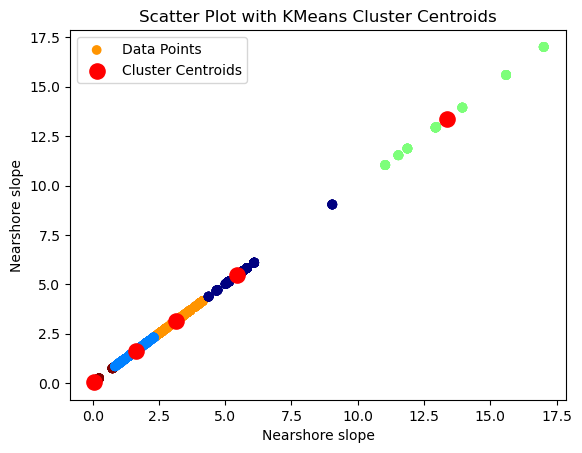

In [295]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# Create a new DataFrame without NaNs
circle_center_nans = circle_center.dropna().copy()

# Fit KMeans clustering to the 3rd column variables
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(circle_center_nans.iloc[:, 2:3])  # Nearshore slope

# Extract cluster centroids
centroids = kmeans.cluster_centers_

# Plot original data points
plt.scatter(circle_center_nans.iloc[:, 2], circle_center_nans.iloc[:, 2], c=kmeans.labels_, cmap='jet', label='Data Points')

# Plot cluster centroids
plt.scatter(centroids[:, 0], centroids[:, 0], s=120, c='red', marker='o', label='Cluster Centroids')

# Add labels and legend
plt.xlabel('Nearshore slope')
plt.ylabel('Nearshore slope')
plt.title('Scatter Plot with KMeans Cluster Centroids')
plt.legend()
plt.show()


In [296]:
kmeans.labels_

array([3, 3, 3, ..., 3, 3, 3])

c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



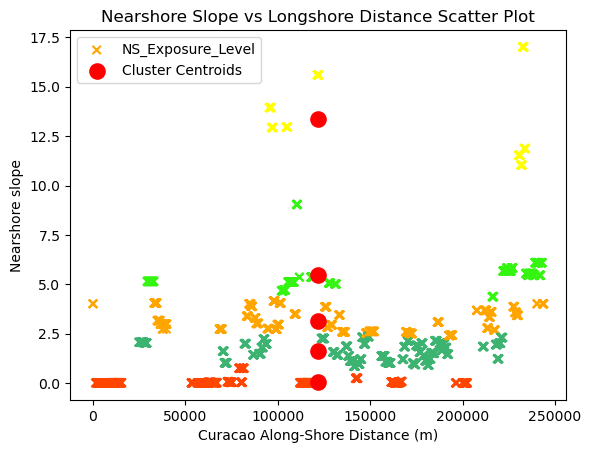

In [297]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# # in the case of *DIRECTLY* proportional variable increase to proportional exposure level increase
# #eg wave heaight higher Hs the Higher the risk

#inverse=False

# in the case of *INVERSELY *proportional variable increase to proportional exposure level increase
#eg Nearshore slope : higher tanB(m) the lower the risk
inverse=False


color_scale = ['#33f510','#3CB371','#FFFF00', '#FFA500','#FF4500']

# if inverse:
#     color_scale = color_scale[::-1]


# Create a new DataFrame without NaNs
circle_center_nans = circle_center.dropna().copy()

# Fit KMeans clustering to the 3rd column variables
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(circle_center_nans.iloc[:, 2:3])   # Nearshore slope column

# kmeans.cluster_centers_ = np.sort(kmeans.cluster_centers_, axis=0)

# Add kmeans.labels_ as a new column to circle_center_nans
circle_center_nans['NS- Exposure level'] = kmeans.labels_ + 1

# Map cluster labels to colors in color_scale
point_colors = [color_scale[label] for label in kmeans.labels_]


# Plot original data points with custom colors
plt.scatter(circle_center_nans.iloc[:, 0], circle_center_nans.iloc[:, 2], c=point_colors, marker='x', label='NS_Exposure_Level')

# Plot cluster centroids
plt.scatter((circle_center_nans.iloc[-1, 0]/2)*(centroids[:, 0]/centroids[:, 0]), centroids[:, 0], s=120, c='red', marker='o', label='Cluster Centroids')

# Add labels and legend
plt.xlabel('Curacao Along-Shore Distance (m)')
plt.ylabel('Nearshore slope')
plt.title('Nearshore Slope vs Longshore Distance Scatter Plot')
plt.legend()
plt.show()


Kmeans sometimes does not rank the clusters proportional ie in increasing order

So we have to manually check and re-sort/re-rank

Also the capability to invert is also added

In [298]:
# in the case of *INVERSELY *proportional variable increase to proportional exposure level increase
#eg Nearshore slope : higher tanB(m) the lower the risk

a=kmeans.cluster_centers_
p = np.sort(a, axis=0)
levels=np.array([1,2,3,4,5]).reshape(-1, 1)


p = np.concatenate((p, a,levels), axis=1)
kmeansissue = pd.DataFrame(p, columns=[f'Column_{i}' for i in range(p.shape[1])])
kmeansissue['Rank'] = kmeansissue['Column_1'].rank(method='min')

if inverse:
    # Define the mapping dictionary
    rank_mapping = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}

    # Map the ranks using the dictionary
    kmeansissue['Rank'] = kmeansissue['Rank'].map(rank_mapping)

kmeansissue

,Column_0,Column_1,Column_2,Rank
0,0.051479,5.455236,1.0,4.0
1,1.615975,1.615975,2.0,2.0
2,3.158241,13.355657,3.0,5.0
3,5.455236,3.158241,4.0,3.0
4,13.355657,0.051479,5.0,1.0


In [299]:
# Map ranks to NS-Exposure level
rank_to_exposure = kmeansissue.set_index('Column_2')['Rank'].to_dict()
circle_center_nans['NS- Exposure level'] = circle_center_nans['NS- Exposure level'].map(rank_to_exposure).astype(int)
circle_center_nans.iloc[100:200,:]




,distance,sampled points,slope,pop_count,Delta_DEM--LECZ_area_per_LECZ_mean_elev,built_up_perc,Sediment Type_Exposure_level,geometry,NS- Exposure level
121,12100,4.0,0.011367,478.0,377954.100882,39.506340,4.0,POINT (-68.85420 12.08432),1
122,12200,4.0,0.011367,478.0,377954.100882,39.506340,4.0,POINT (-68.85485 12.08428),1
123,12300,4.0,0.011367,478.0,377954.100882,39.506340,4.0,POINT (-68.85507 12.08385),1
124,12400,4.0,0.011367,478.0,377954.100882,39.506340,4.0,POINT (-68.85540 12.08462),1
125,12500,4.0,0.011367,478.0,377954.100882,39.506340,4.0,POINT (-68.85579 12.08374),1
...,...,...,...,...,...,...,...,...,...
313,31300,5.0,5.143658,2439.0,278959.265959,50.798025,4.0,POINT (-68.90064 12.08766),4
314,31400,5.0,5.143658,2439.0,278959.265959,50.798025,4.0,POINT (-68.90096 12.08790),4
315,31500,4.0,5.143658,2439.0,278959.265959,50.798025,4.0,POINT (-68.90171 12.08780),4
316,31600,4.0,5.143658,2439.0,278959.265959,50.798025,4.0,POINT (-68.90186 12.08805),4


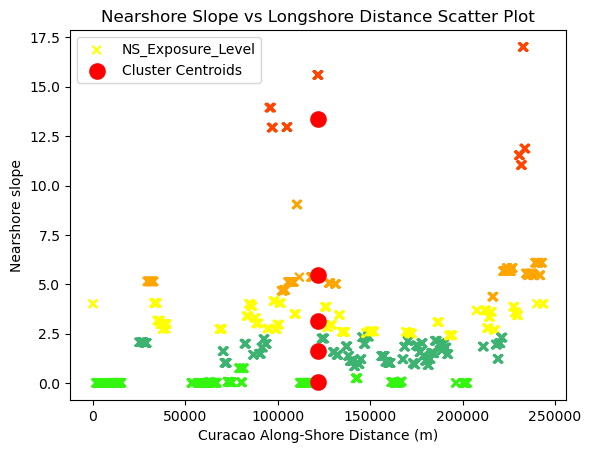

In [300]:
point_colors = [color_scale[label] for label in circle_center_nans['NS- Exposure level']-1]

# Plot original data points with custom colors
plt.scatter(circle_center_nans.iloc[:, 0], circle_center_nans.iloc[:, 2], c=point_colors, marker='x', label='NS_Exposure_Level')

# Plot cluster centroids
plt.scatter((circle_center_nans.iloc[-1, 0]/2)*(centroids[:, 0]/centroids[:, 0]), centroids[:, 0], s=120, c='red', marker='o', label='Cluster Centroids')

# Add labels and legend
plt.xlabel('Curacao Along-Shore Distance (m)')
plt.ylabel('Nearshore slope')
plt.title('Nearshore Slope vs Longshore Distance Scatter Plot')
plt.legend()
plt.show()

Create a function to make future use easier

In [301]:
# def kmeans_inverter_func(cluster_centers):

#     #Assume direct proportionality just for visualization 
    
#     a=cluster_centers
#     p = np.sort(a, axis=0)
#     levels=np.array([1,2,3,4,5]).reshape(-1, 1)
#     if inverse:
#         levels = levels[::-1]

#     p = np.concatenate((p, a,levels), axis=1)
#     kmeansissue = pd.DataFrame(p, columns=[f'Column_{i}' for i in range(p.shape[1])])
#     kmeansissue['Rank'] = kmeansissue['Column_1'].rank(method='min')


In [302]:
circle_center_nans

,distance,sampled points,slope,pop_count,Delta_DEM--LECZ_area_per_LECZ_mean_elev,built_up_perc,Sediment Type_Exposure_level,geometry,NS- Exposure level
0,0,4.0,4.010837,140.0,289736.126650,17.732094,4.0,POINT (-68.84834 12.06170),3
1,100,4.0,4.010837,140.0,289736.126650,17.732094,4.0,POINT (-68.84912 12.06225),3
2,200,4.0,4.010837,140.0,289736.126650,17.732094,4.0,POINT (-68.84990 12.06286),3
15,1500,5.0,0.003349,202.0,382253.360104,21.945391,4.0,POINT (-68.85004 12.07313),1
16,1600,5.0,0.003349,202.0,382253.360104,21.945391,4.0,POINT (-68.84980 12.07377),1
...,...,...,...,...,...,...,...,...,...
2435,243500,4.0,4.010837,74.0,244939.371945,15.372980,4.0,POINT (-68.84468 12.06005),3
2436,243600,4.0,4.010837,74.0,244939.371945,15.372980,4.0,POINT (-68.84559 12.06048),3
2437,243700,4.0,4.010837,140.0,289736.126650,17.732094,4.0,POINT (-68.84652 12.06084),3
2438,243800,4.0,4.010837,140.0,289736.126650,17.732094,4.0,POINT (-68.84744 12.06124),3


In [303]:
color_scale = ['#33f510','#3CB371', '#FFFF00', '#FFA500'  ,'#FF4500']

fig2 = go.Figure(go.Scattermapbox(
    lat=circle_center_nans["geometry"].y,
    lon=circle_center_nans["geometry"].x,
    mode='markers',
    marker=dict(
        size=15,
        color=circle_center_nans["NS- Exposure level"],  # Set color to red
         colorscale=color_scale,  # Specify the discrete color scale

        # colorscale=color_scale,  # Specify the discrete color scale
        # cmin=1,  # Set the minimum value for the color scale
        # cmax=6,  # Set the maximum value for the color scale
        colorbar=dict(
            # title=f'Curacao chainage starting counterclockwise from lon= {circle_center["geometry"][0].x:.2f} and lat= {circle_center["geometry"][0].y:.2f}'  # Set color bar title?
            title = (
                        f'Nearshore Slope- Exposure Level'
                    )            
        )
    ),
    hoverinfo='text',
    hovertext=circle_center_nans['slope'],
    showlegend=False
))

# Update layout properties
fig2.update_layout(
    title = f"Curacao Nearshore Slope Exposure Level <br>at 100m spacing starting counterclockwise from:<br> Point lon={circle_center['geometry'][0].x:.2f}° and lat={circle_center['geometry'][0].y:.2f}°",
    mapbox_style="carto-positron",
    mapbox=dict(
        zoom=9.5,
        center=dict(lat=12.18625, lon=-68.95)
    ),		

    margin=dict(l=0, r=50, b=0, t=100),
    legend=dict(
    x=1.15,
    y=1.0,
    traceorder="normal",
    orientation="v"
),
    width=800,  # Set width of the plot
    height=600  # Set height of the plot
)

# Show the plot
fig2.show()

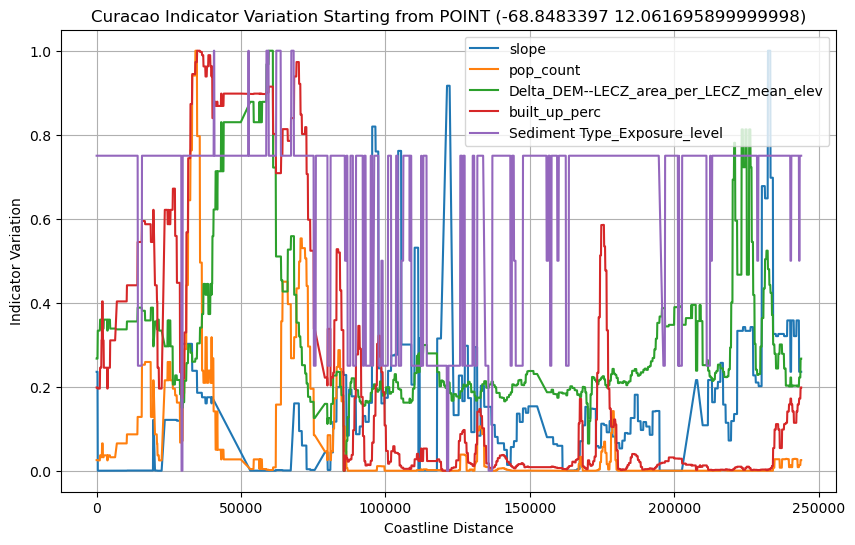

In [304]:
#Min_Max Scaling


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(10, 6))  

columns_to_scale = circle_center.columns[2:-1]  # Starting from the third column to the end
circle_center_scaled=circle_center

# Perform Min-Max scaling
scaler = MinMaxScaler()
circle_center_scaled[columns_to_scale] = scaler.fit_transform(circle_center_scaled[columns_to_scale])

# Plotting the line graph using Seaborn
for column in circle_center_scaled.columns[2:-1]:
    sns.lineplot(data=circle_center_scaled, x='distance', y=column, label=column)

plt.title(f'Curacao Indicator Variation Starting from {circle_center_scaled["geometry"][0]}')
plt.xlabel('Coastline Distance')
plt.ylabel('Indicator Variation')
plt.grid(True)
plt.show()

c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\U

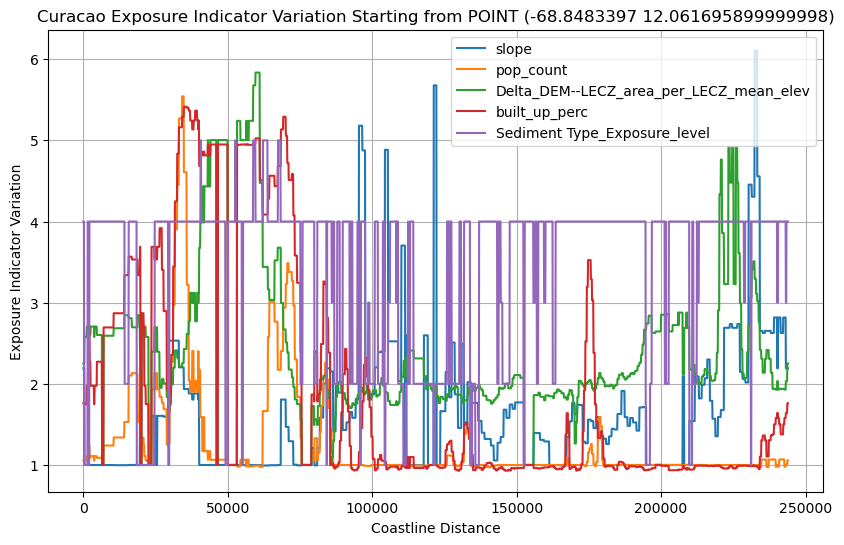

In [305]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

plt.figure(figsize=(10, 6))

columns_to_scale = circle_center.columns[2:-1]  # Starting from the third column to the end
circle_center_scaled=circle_center.dropna().copy()
# circle_center_scaled = circle_center.fillna(circle_center.min()).copy()

# Select numerical columns only not geometry
numeric_columns = circle_center.select_dtypes(include=np.number)

# Replace NaN values with the minimum value of each respective column
circle_center_filled = circle_center.copy()
circle_center_filled[numeric_columns.columns] = numeric_columns.fillna(numeric_columns.min())

# Make a copy to avoid modifying the original DataFrame
circle_center_scaled = circle_center_filled.copy()


# Perform KMeans clustering-based scaling
for column in columns_to_scale:
    # Fit KMeans model
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(circle_center_scaled[[column]])
    
    #sort to ensure maximum value occurs
    kmeans.cluster_centers_ = np.sort(kmeans.cluster_centers_, axis=0)

    # Transform values based on cluster centroids
    scaled_values = kmeans.transform(circle_center_scaled[[column]])
    #insert_solution function
    
    scaled_values = 1 + (scaled_values - kmeans.cluster_centers_.min()) / (kmeans.cluster_centers_.max() - kmeans.cluster_centers_.min()) * 4
    
    circle_center_scaled[column] = scaled_values

# Plotting the line graph using Seaborn
for column in circle_center_scaled.columns[2:-1]:
    sns.lineplot(data=circle_center_scaled, x='distance', y=column, label=column)

plt.title(f'Curacao Exposure Indicator Variation Starting from {circle_center_scaled["geometry"][0]}')
plt.xlabel('Coastline Distance')
plt.ylabel('Exposure Indicator Variation')
plt.grid(True)
plt.show()


c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\rowe\AppData\Local\miniconda3\envs\coclico\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\U

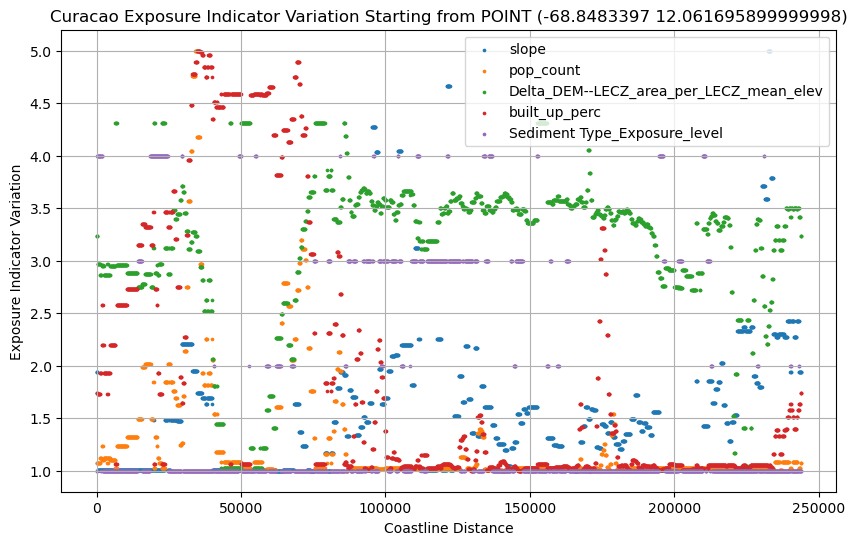

In [306]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

plt.figure(figsize=(10, 6))

columns_to_scale = circle_center.columns[2:-1]  # Starting from the third column to the end
circle_center_scaled=circle_center.dropna().copy()
# circle_center_scaled = circle_center.fillna(circle_center.min()).copy()

# Select numerical columns only not geometry
numeric_columns = circle_center.select_dtypes(include=np.number)

# Replace NaN values with the minimum value of each respective column
circle_center_filled = circle_center.copy()
circle_center_filled[numeric_columns.columns] = numeric_columns.fillna(numeric_columns.min())

# Make a copy to avoid modifying the original DataFrame
circle_center_scaled = circle_center_filled.copy()


# Perform KMeans clustering-based scaling
for column in columns_to_scale:
    # Fit KMeans model
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(circle_center_scaled[[column]])
    
    # Transform values based on cluster centroids
    scaled_values = kmeans.transform(circle_center_scaled[[column]])
    scaled_values = 1 + (scaled_values - scaled_values.min()) / (scaled_values.max() - scaled_values.min()) * 4
    
    circle_center_scaled[column] = scaled_values

# Plotting the line graph using Seaborn
for column in circle_center_scaled.columns[2:-1]:
    sns.scatterplot(data=circle_center_scaled, x='distance', y=column, label=column, s=7,linewidth=0)

plt.title(f'Curacao Exposure Indicator Variation Starting from {circle_center_scaled["geometry"][0]}')
plt.xlabel('Coastline Distance')
plt.ylabel('Exposure Indicator Variation')
plt.grid(True)
plt.show()


In [307]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

plt.figure(figsize=(10, 6))

columns_to_scale = circle_center.columns[3:]  # Starting from the third column to the end

# Perform KMeans clustering-based scaling
for column in columns_to_scale:
    # Fit KMeans model
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(circle_center[[column]])
    
    # Transform values based on cluster centroids
    scaled_values = kmeans.transform(circle_center[[column]])
    scaled_values = 1 + (scaled_values - scaled_values.min()) / (scaled_values.max() - scaled_values.min()) * 4
    
    # Round scaled values to the nearest integer
    scaled_values = np.round(scaled_values).astype(int)
    
    circle_center[column] = scaled_values

# Plotting the line graph using Seaborn
for column in circle_center.columns[3:]:
    sns.lineplot(data=circle_center, x='distance', y=column, label=column)

plt.title(f'Curacao Indicator Variation Starting from {circle_center["geometry"][0]}')
plt.xlabel('Coastline Distance')
plt.ylabel('Indicator Level')
plt.grid(True)
plt.show()


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

<Figure size 1000x600 with 0 Axes>

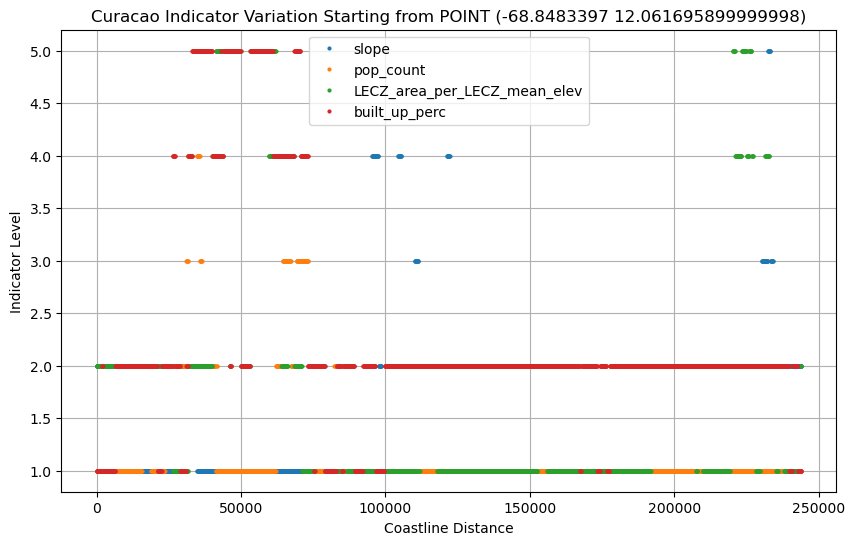

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

plt.figure(figsize=(10, 6))

columns_to_scale = circle_center.columns[3:]  # Starting from the third column to the end

# Perform KMeans clustering-based scaling
for column in columns_to_scale:
    # Fit KMeans model
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(circle_center[[column]])
    
    # Transform values based on cluster centroids
    scaled_values = kmeans.transform(circle_center[[column]])
    scaled_values = 1 + (scaled_values - scaled_values.min()) / (scaled_values.max() - scaled_values.min()) * 4
    
    # Round scaled values to the nearest integer
    scaled_values = np.round(scaled_values).astype(int)
    
    circle_center[column] = scaled_values

# Plotting the line graph using Seaborn
for column in circle_center.columns[3:]:
    sns.lineplot(data=circle_center, x='distance', y=column, label=column, marker="o",linewidth=0, markeredgewidth=0,markersize=3)

plt.title(f'Curacao Indicator Variation Starting from {circle_center["geometry"][0]}')
plt.xlabel('Coastline Distance')
plt.ylabel('Indicator Level')
plt.grid(True)
plt.show()
